In [1]:
# Note: This example is different from the one in the book, as I thought this one is more intuitive.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.special import gamma, gammaln, gammasgn
pd.options.display.max_rows=1000

### First, let's generate some data

In [35]:
ene = 1
pe = 0.3
tam = 10
data_sample = st.binom.rvs(n=ene, p=pe, size=tam, random_state=7)

### Now let's start constructing CI's on it

In [36]:
alpha = 0.05
p_hat = np.sum(data_sample) / (ene * tam)
n_tosses = data_sample.shape[0]
x_p_hat = [np.floor(p_hat * n_tosses), np.ceil(p_hat * n_tosses)]

In [37]:
(p_hat, x_p_hat)

(0.3, [3.0, 3.0])

In [38]:
p_grid_lo = np.linspace(0,p_hat,1000)
p_grid_hi = np.linspace(p_hat,1,1000)

In [39]:
surv_func = [np.mean(st.binom.sf(x_p_hat, n=n_tosses, p=val)) for val in p_grid_lo]
cd_func = [np.mean(st.binom.cdf(x_p_hat, n=n_tosses, p=val)) for val in p_grid_hi]

In [40]:
surv_df = pd.DataFrame({'p_hat_grid':p_grid_lo, 'surv_func':surv_func})
cdf_df = pd.DataFrame({'p_hat_grid':p_grid_hi, 'cd_func':cd_func})

In [41]:
phat_lo = (surv_df.loc[surv_df['surv_func']<=alpha/2, 'p_hat_grid'].iloc[-1] + 
           surv_df.loc[surv_df['surv_func']>=alpha/2, 'p_hat_grid'].iloc[0]) / 2
phat_lo

0.12147147147147147

In [42]:
phat_hi = (cdf_df.loc[cdf_df['cd_func']<=alpha/2, 'p_hat_grid'].iloc[0] + 
           cdf_df.loc[cdf_df['cd_func']>=alpha/2, 'p_hat_grid'].iloc[-1]) / 2
phat_hi

0.6528028028028028

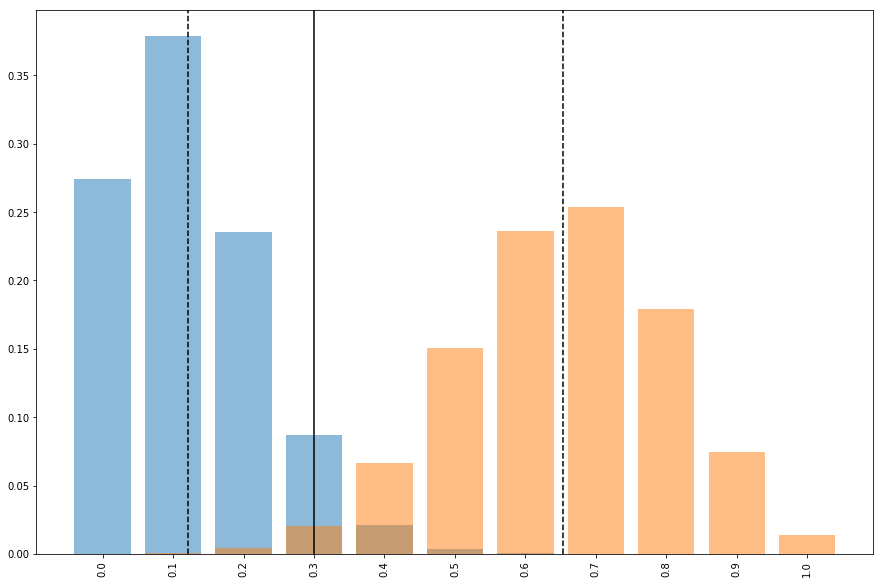

In [43]:
plt.figure(figsize=(15,10))
plt.bar(np.linspace(0,n_tosses, n_tosses+1),st.binom.pmf(np.linspace(0,n_tosses, n_tosses+1), n_tosses ,phat_lo), alpha=0.5)
plt.bar(np.linspace(0,n_tosses, n_tosses+1),st.binom.pmf(np.linspace(0,n_tosses, n_tosses+1), n_tosses ,phat_hi), alpha=0.5)
plt.xticks(np.linspace(0,n_tosses, n_tosses+1), np.linspace(0,n_tosses, n_tosses+1)/n_tosses, rotation=90)
plt.axvline(np.mean(x_p_hat), c='k')
plt.axvline(phat_lo * n_tosses, c='k', ls='--')
plt.axvline(phat_hi * n_tosses, c='k', ls='--')
plt.show()

In [44]:
np.mean(st.binom.cdf(x_p_hat, p=phat_lo, n=n_tosses))

0.9750559616291328

In [45]:
np.mean(st.binom.sf(x_p_hat, p=phat_hi, n=n_tosses))

0.9751435674001966

### Four ways to calculate confidence intervals using Bootstrap Techniques

First, using standard CI's

In [46]:
from sklearn.utils import resample

In [47]:
theta_boot = list() 
B = 2000

for b in range(B):
    theta_boot.append(np.mean(resample(data_sample)))
    
theta_dot_boot = np.mean(theta_boot)
theta_std_boot = np.std(theta_boot)
(theta_dot_boot, theta_std_boot)

(0.30110000000000003, 0.1438707405972458)

In [48]:
# Now, compute standard 95% two-tailed CI.
ci = (theta_dot_boot - 1.96 * theta_std_boot, theta_dot_boot + 1.96 * theta_std_boot)
ci

(0.01911334842939827, 0.5830866515706018)

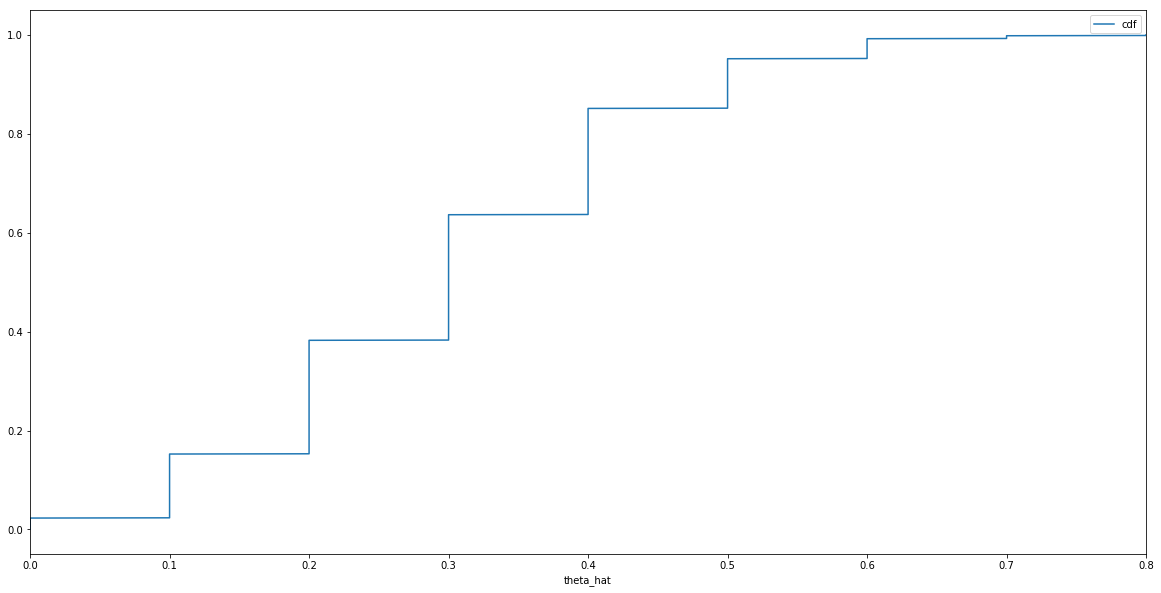

In [49]:
# Now, using the percentile method
boot_cdf = pd.DataFrame({'theta_hat': theta_boot}).sort_values('theta_hat')
boot_cdf['nrow'] = np.linspace(1, boot_cdf.shape[0], boot_cdf.shape[0])
boot_cdf['cdf'] = boot_cdf['nrow'] / boot_cdf['nrow'].iloc[-1]
boot_cdf.plot(x='theta_hat', y='cdf', figsize=(20,10))

In [50]:
ci = (np.percentile(theta_boot, 0.025 * 100), np.percentile(theta_boot, 0.975 * 100))
ci

(0.1, 0.6)

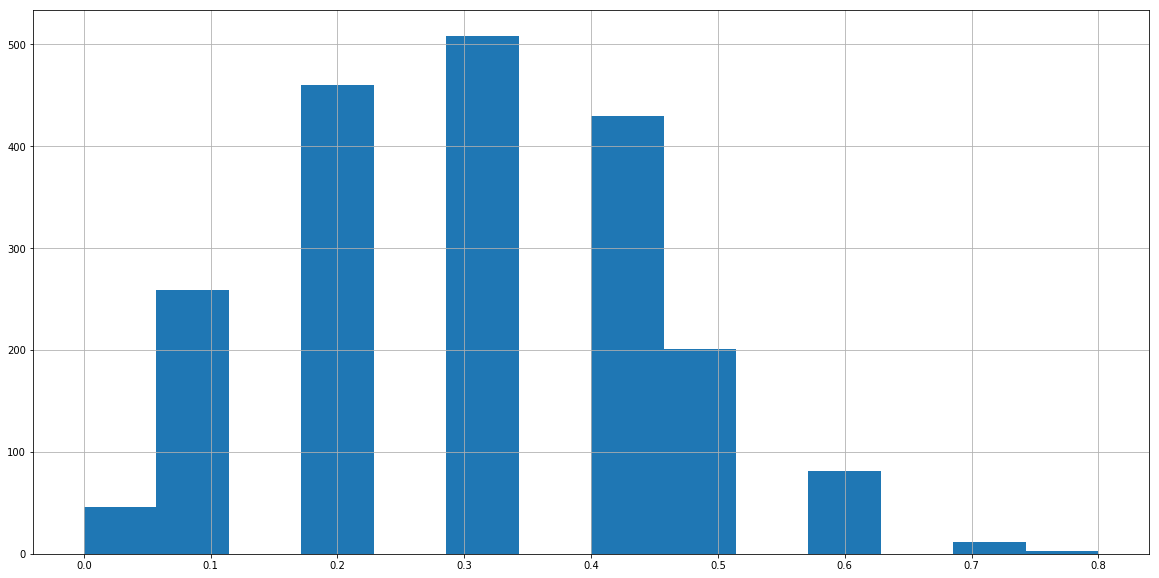

In [51]:
boot_cdf['theta_hat'].hist(bins=14, figsize=(20,10))

In [52]:
# PDF asymmetric

In [53]:
st.skew(boot_cdf['theta_hat'])

0.24469604983868898

In [54]:
# Now, let's work using the logits
phi_boot = list() 
B = 2000

for b in range(B):
    log1p = np.log1p(np.mean(resample(data_sample)) / (1- np.mean(resample(data_sample))) if np.mean(resample(data_sample)) < 1 else 0)
    phi_boot.append(log1p)
    
phi_dot_boot = np.mean(phi_boot)
phi_std_boot = np.std(phi_boot)
(phi_dot_boot, phi_std_boot)

(0.35706722276781, 0.16921328557136672)

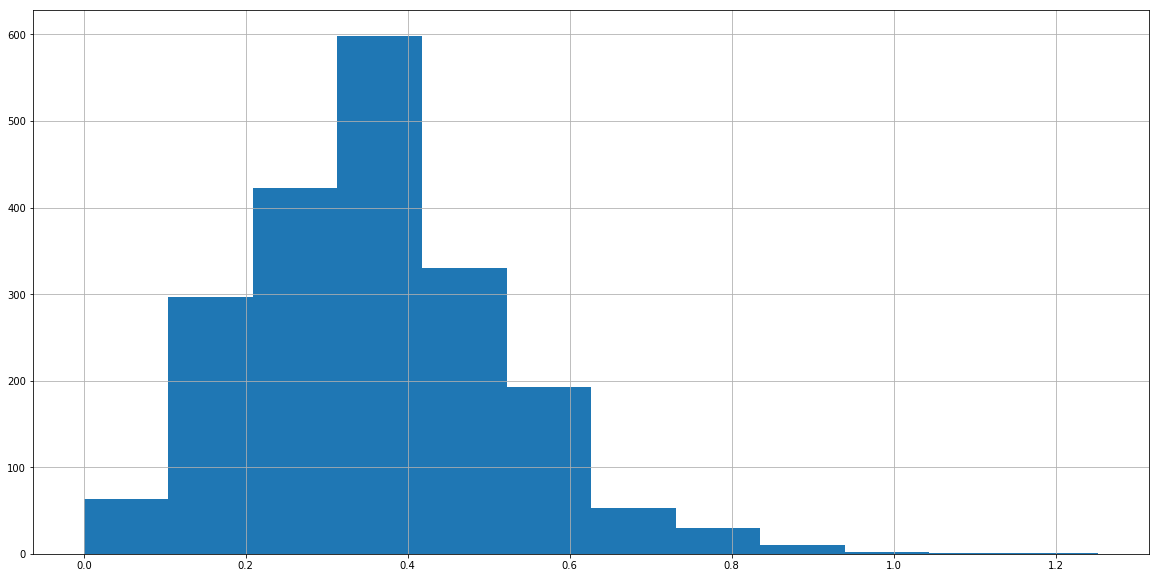

In [55]:
# Now, using the percentile method
boot_cdf = pd.DataFrame({'phi_hat': phi_boot}).sort_values('phi_hat')
boot_cdf['phi_hat'].hist(bins=12, figsize=(20,10))

In [56]:
st.skew(boot_cdf['phi_hat'])

0.4526064420705703